In [31]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, time
import gzip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
from pandas import json_normalize

In [32]:
# LOCAL = 'Avenches'
LOCAL = 'Lausanne'
group_to_type = {
    0: 'home',
    1: 'education',
    2: 'work',
    3: 'leisure',
    4: 'shop'
}
HORIZON = 289

In [33]:
# Specify the file paths
activity_file = 'data_original/vaud_activities.csv.gz'
population_file = 'data_original/vaud_population.csv.gz'
trip_file = 'data_original/vaud_trips.csv.gz'

# Read the gzipped CSV files
def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

# Read the dataframes
activity_vaud = read_gzipped_csv(activity_file)
population_vaud = read_gzipped_csv(population_file)[['id', 'age', 'home_x', 'home_y', 'local']].drop_duplicates()
trip_vaud = read_gzipped_csv(trip_file)[['Unnamed: 0', 'id', 'mode', 'dep_time','trav_time','start_link','end_link']].drop_duplicates()

#### Generic functions :

In [34]:
# Create palette of colors for the facilities type
palette = sns.color_palette("husl", n_colors=len(set(activity_vaud['type'])))
color_palette = dict(zip(set(activity_vaud['type']), palette))
color_palette['transport'] = 'grey'

In [35]:
def plot_schedule_dataset(activity_df, individual_id):
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    
    segments = []
    colors = []
    fig, ax = plt.subplots(figsize=(10, 1))
    
    start_of_day = datetime.strptime('00:00:00', '%H:%M:%S')
    end_of_day = datetime.strptime('23:59:59', '%H:%M:%S')
    prev_end = start_of_day
    
    for _, facility in individual_schedule.iterrows():
        start_time = datetime.strptime(facility['start_time'], '%H:%M:%S') if pd.notna(facility['start_time']) else start_of_day
        end_time = datetime.strptime(facility['end_time'], '%H:%M:%S') if pd.notna(facility['end_time']) else end_of_day
        
        if prev_end < start_time:
            segments.append([(prev_end - start_of_day).total_seconds() / 3600, (start_time - prev_end).total_seconds() / 3600])
            colors.append(color_palette['transport'])
            ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
            
        segments.append([(start_time - start_of_day).total_seconds() / 3600, (end_time - start_time).total_seconds() / 3600])
        colors.append(color_palette[facility['type']])
        ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
        
        prev_end = end_time


    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlim(0, 24)
    ax.set_yticks([])
    ax.set_xticks(range(25))
    ax.set_xlabel('Time (hours)')
    plt.show()

In [36]:
def print_schedule(activity_df, individual_id):
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    print(tabulate(individual_schedule, headers='keys', tablefmt='pipe'))

In [37]:
def horizons_to_timedelta(n):
    minutes = n * 5
    time_delta = timedelta(minutes=minutes)
    return time_delta

In [38]:
def json_to_flat_dataframe(json_path):
    with open(json_path, 'r') as file:
        data = pd.read_json(file)
    
    # Normalize the 'daily_schedule' data to create a flat table
    # We will concatenate all the schedules along with their top-level data such as 'id', 'execution_time', etc.
    flat_data = pd.DataFrame()  # Empty dataframe to hold our flattened data
    for record in data.to_dict(orient='records'):
        # Normalize the daily_schedule for each record
        schedule_df = json_normalize(record, 'daily_schedule', errors='ignore')
        
        # Adding the top-level data as new columns to the schedule_df
        for col in data.columns.difference(['daily_schedule']):
            schedule_df[col] = record[col]
        
        # Append to the flat_data DataFrame
        flat_data = pd.concat([flat_data, schedule_df], ignore_index=True)
    
    return flat_data

In [39]:
def minutes_to_time2(minute_value):
    total_minutes = minute_value * 5
    hours, minutes = divmod(total_minutes, 60)
    if hours >= 24:
        hours = hours % 24
    return time(hour=int(hours), minute=int(minutes))

In [40]:
def filter_and_sort_activities(df):
    # Convert 'start' and 'duration' from time objects to timedeltas for comparison
    df['duration_td'] = df['duration'].apply(lambda x: pd.to_timedelta(x.strftime('%H:%M:%S')))
    
    # Group by 'acity' and find the index of the row with the maximum duration
    idx = df.groupby('acity')['duration_td'].idxmax()
    
    # Select only the rows with the maximum duration
    max_duration_df = df.loc[idx]
    
    # Drop the auxiliary 'duration_td' column
    max_duration_df = max_duration_df.drop(columns=['duration_td'])
    
    # Now, sort the resulting DataFrame by the 'start' column
    max_duration_df = max_duration_df.sort_values(by='start')
    
    return max_duration_df

In [41]:
# Helper function to convert a time object to minutes
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# Helper function to convert minutes to a time object
def minutes_to_time(minutes):
    hours, minutes = divmod(minutes, 60)
    return time(hour=hours, minute=minutes)

# Function to calculate the end time of activities
def calculate_end_time(row):
    # Handle the special case for the last row
    if row.name == df.last_valid_index():
        return time(23, 59, 0)

    start_minutes = time_to_minutes(row['start'])
    duration_minutes = time_to_minutes(row['duration'])
    end_minutes = start_minutes + duration_minutes

    return minutes_to_time(end_minutes)

In [42]:
def plot_schedule_json(df, individual_id):
    individual_schedule = df[df['id'] == individual_id].sort_values(by='start')
    
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xticks(range(0, 25, 1))
    ax.set_xlabel('Time (hours)')
    
    # Convert time objects to hours since the start of the day
    time_to_hours = lambda t: t.hour + t.minute / 60 + t.second / 3600
    
    prev_end_time = time_to_hours(datetime.strptime('00:00:00', '%H:%M:%S').time())
    
    # Iterate over the activities
    for _, activity in individual_schedule.iterrows():
        start_time = time_to_hours(activity['start'])
        end_time = time_to_hours(activity['end_time'])
        
        # If there is a gap between the previous end time and the current start time, plot it as 'transport'
        if prev_end_time < start_time:
            ax.broken_barh([(prev_end_time, start_time - prev_end_time)], (0, 1), facecolors=color_palette['transport'])
        
        ax.broken_barh([(start_time, end_time - start_time)], (0, 1), facecolors=color_palette[activity['group']])
        
        prev_end_time = end_time

    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [43]:
def reorder_df(df):
    new_order = [
        'acity', 'facility', 'group', 'start', 'duration', 'end_time', 'time',
        'cum_utility', 'DSSR_iterations', 'execution_time', 'id', 'utility'
    ]
    df = df[new_order]
    return df

In [44]:
def compare_individual_schedules(df_dataset, df_json, individual_id):
    print("Here is his/her schedule in the original dataframe :\n")
    print_schedule(df_dataset, individual_id)
    plot_schedule_dataset(df_dataset, individual_id)
    print("Here is his/her schedule with our planning algorythm :\n")
    print_schedule(df_json, individual_id)
    plot_schedule_json(df_json, individual_id)

#### Tests :

In [45]:
path_to_json_file = "data_output/schedules.json"
df = json_to_flat_dataframe(path_to_json_file)
# df.head()

In [46]:
df['start'] = df['start'].apply(minutes_to_time2)
df['duration'] = df['duration'].apply(minutes_to_time2)
df['time'] = df['time'].apply(minutes_to_time2)
# df.head()

In [47]:
filtered_df = filter_and_sort_activities(df)
# filtered_df.head()

In [48]:
filtered_df['end_time'] = filtered_df.apply(calculate_end_time, axis=1)
# filtered_df.head()

In [49]:
schedule_postprocessed = reorder_df(filtered_df)
# schedule_postprocessed.head()

Here is his/her schedule in the original dataframe :

|         |   Unnamed: 0 |      id | type   | facility    |   link |           x |           y | start_time   | end_time   |
|--------:|-------------:|--------:|:-------|:------------|-------:|------------:|------------:|:-------------|:-----------|
| 4377485 |     36624115 | 7120345 | home   | home3124988 | 129407 | 2.53731e+06 | 1.1523e+06  | nan          | 07:04:18   |
| 4377486 |     36624116 | 7120345 | work   | 223384      | 596687 | 2.53934e+06 | 1.15468e+06 | 07:19:18     | 11:04:18   |
| 4377487 |     36624117 | 7120345 | home   | home3124988 | 129407 | 2.53731e+06 | 1.1523e+06  | 11:19:18     | 12:34:18   |
| 4377488 |     36624118 | 7120345 | work   | 223384      | 596687 | 2.53934e+06 | 1.15468e+06 | 12:49:18     | 16:04:18   |
| 4377489 |     36624119 | 7120345 | shop   | 398396      | 205618 | 2.53611e+06 | 1.15773e+06 | 16:29:18     | 17:19:18   |
| 4377490 |     36624120 | 7120345 | home   | home3124988 | 129407 | 2.

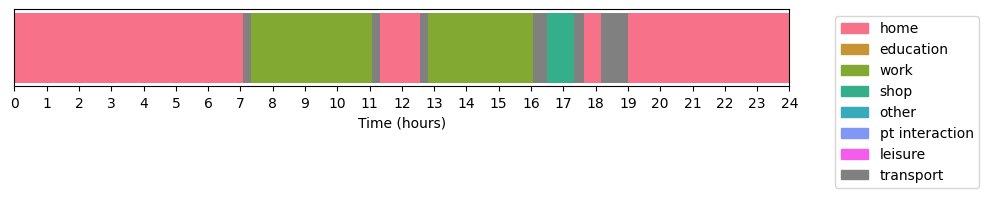

Here is his/her schedule with our planning algorythm :

|     |   acity |   facility | group     | start    | duration   | end_time   | time     |   cum_utility |   DSSR_iterations |   execution_time |      id |   utility |
|----:|--------:|-----------:|:----------|:---------|:-----------|:-----------|:---------|--------------:|------------------:|-----------------:|--------:|----------:|
|   0 |       0 |          0 | home      | 00:00:00 | 00:05:00   | 00:05:00   | 00:05:00 |             0 |                22 |            0.498 | 7120345 |         0 |
|  46 |       5 |     445588 | leisure   | 00:20:00 | 04:15:00   | 04:35:00   | 04:35:00 |             0 |                22 |            0.498 | 7120345 |         0 |
|  47 |      23 |          0 | home      | 04:50:00 | 00:05:00   | 04:55:00   | 04:55:00 |             0 |                22 |            0.498 | 7120345 |         0 |
|  64 |      20 |      92517 | work      | 05:05:00 | 01:50:00   | 06:55:00   | 06:55:00 |             0

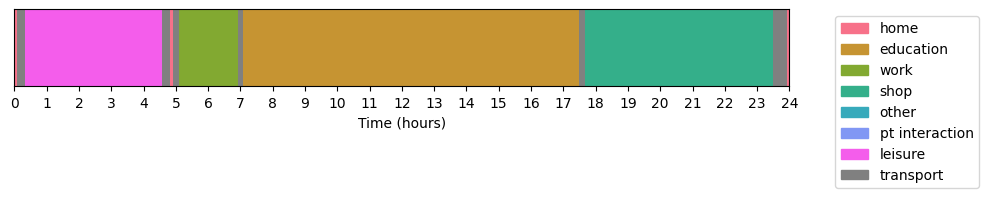

In [30]:
compare_individual_schedules(activity_vaud, schedule_postprocessed, 7120345)